In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn
import re
import itertools

# Automating Reports: Supermarket Sales

## Read input

In [46]:
base_df = pd.read_csv('supermarket_sales.csv')
base_df.shape

(1000, 17)

In [47]:
base_df.head(5)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [3]:
base_df[base_df.duplicated()]

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating


In [4]:
base_df.groupby(['Branch', 'City', 'Customer type', 'Gender']).agg({'Invoice ID':'count'})

Invoice ID
Branch City      Customer type Gender            
A      Yangon    Member        Female          80
                               Male            87
                 Normal        Female          81
                               Male            92
B      Mandalay  Member        Female          85
                               Male            80
                 Normal        Female          77
                               Male            90
C      Naypyitaw Member        Female          96
                               Male            73
                 Normal        Female          82
                               Male            77

## Creating deliverable

We want our script to:


In [68]:
def create_deliverables(input_df, target_branch = 'A' , start_date = 'min', end_date = 'max', report_request = {}):
    """This function receives a dataframe and create a set of charts and metrics to be used in a PDF report.
    Params:
        1. input_df: its the dataset to be analysed.
        2. rep_type: accepts two values, global for a general report or branch for a empathized report. <--- 
        3. start - end_date: by default, takes the min and max date on the dataset or the user input expressed as a %m/%d/%Y date"""
    
    #1. Set basic variables
    output = {}
    log = []
    
    log.append(f"Starting function having parameters: target_branch = {target_branch}")
    
    #2. Fix - adjust dataframe
    input_df['Date_Time'] = pd.to_datetime((input_df['Date'] + ' ' + input_df['Time']), format='%m/%d/%Y %H:%M')  
        
    min_date = input_df['Date_Time'].min() if start_date == 'min' else datetime.datetime.strptime(start_date, '%m/%d/%Y')
    max_date = input_df['Date_Time'].max() if end_date == 'max' else datetime.datetime.strptime(end_date, '%m/%d/%Y') + datetime.timedelta(days = 1) #this extra day is used to cover the limit day selected by the user
    
    log.append(f'Report star date is: {min_date} Report end date: {max_date}')
    
    #3. Filter dataset as per required criteria
    
    input_df = input_df[(input_df['Date_Time'] >= min_date) & (input_df['Date_Time'] <= max_date)]

    #4. Create deliverables
    for requirement in report_request:
        if report_request[requirement]['type'] == 'bar':
            print(create_visual_bar(input_df, target_branch, requirement, report_request[requirement]['compare'], report_request[requirement]['categories'], report_request[requirement]['ops']))
    return 

In [85]:
def create_visual_bar(input_df, target_branch, title, compare, categories = [], ops = {}):
    """This functions receives a grouped df and returns a bar chart"""
    # create grouped df
    log = [f'Processing: {title}']
    
    if 'hour' in categories:
        input_df['hour'] = input_df['Date_Time'].dt.hour
        
    if 'day_name' in categories:
        input_df['day_name'] = input_df['Date_Time'].dt.day_name()
    
    df_subsets = []
    if compare == True:
        for branch in input_df['Branch'].unique():
            df_subsets.append(input_df[input_df['Branch'] == branch])
    else:
        df_subsets.append(input_df[input_df['Branch'] == target_branch])
    
    grouped_df = pd.DataFrame()
    
    for indx, subset in enumerate(df_subsets):
        col_names = {}
        for op in ops:
            col_names[op] = f"{op} Branch {subset['Branch'].unique()[0]}"
        if indx == 0:
            grouped_df = subset.groupby(categories).agg(ops).rename(columns=col_names)
        else:
            grouped_df = grouped_df.merge(subset.groupby(categories).agg(ops).rename(columns=col_names), left_index=True, right_index=True)
      
    #column analysis
    total_cols = []
    for col in grouped_df.columns:
        total_cols.append(col)
        
    width = (1 / len(total_cols)) - 0.07    
    
    if isinstance(grouped_df.index, pd.MultiIndex): #cust_breakout or gender_breakout = True
        print('multiindex condition')
        #index analysis    
        factor_names = grouped_df.index.names
        factor_number = len(factor_names)
        factor_levels = {}
        
        for index in grouped_df.index:
            for factor in range(factor_number):
                if factor_levels.get(factor_names[factor]) == None:
                    factor_levels[factor_names[factor]] = {index[factor]}
                else:
                    factor_levels[factor_names[factor]].add(index[factor])   
        print(f'factor levels: {factor_levels}')   #---- temp line     
        factor_levels.pop(list(factor_levels.keys())[-1])
        df_filters = list(itertools.product(*factor_levels.values()))
        print(f'df filters: {df_filters}')
        
        # Chart Prepare
        df_filters_len = len(df_filters)
        if df_filters_len == 2:
            fig, axs = plt.subplots(ncols=2, nrows = 1, figsize=(7,2.5))
            plot_seq = enumerate(df_filters)
        elif df_filters_len == 4:
            fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(7,5))
            plot_seq = zip([(0,0), (0,1), (1,0), (1,1)], df_filters)  
        elif df_filters_len == 6: 
            fig, axs = plt.subplots(ncols=2, nrows = 3, figsize=(7,7.5))
            plot_seq = zip([(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)], df_filters)
        elif df_filters_len == 7: 
            fig, axs = plt.subplots(ncols=4, nrows = 2, figsize=(9,5)) #for the special case of weekday as factor
            plot_seq = zip([(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)], df_filters)
        
        fig.suptitle(title) 
        fig.tight_layout(pad=2.2, w_pad=0.05, h_pad=3)
        
        for chart_indx, segment in plot_seq:
            filtered_df =  grouped_df
            segment_title = ''
            for val_indx, factor in enumerate(factor_levels.keys()):
                segment_title += str(segment[val_indx]) + ' '
                filtered_df =  filtered_df[filtered_df.index.isin([segment[val_indx]], level=val_indx)]
               
            filtered_df.reset_index(inplace = True)
            index_col_val = filtered_df[factor_names[-1]].unique() #this variable helps detect special cases where specific order is needed, example: days, months
            
            # this section adjust x labels to avoid presenting numbers as x_ticks
            if 'Monday' in index_col_val: #adjust days
                mapping = {'Monday':0, 'Tuesday':1 , 'Wednesday':2 , 'Thursday':3 , 'Friday':4 , 'Saturday':5 , 'Sunday':6}
                filtered_df['cat_code'] = filtered_df[factor_names[-1]].map(mapping)
            elif 'January' in index_col_val: #to do
                pass 
            else:
                filtered_df['cat_code'] = filtered_df[factor_names[-1]].astype('category').cat.codes
                
            filtered_df.sort_values(by = 'cat_code', ascending = True, inplace=True)
            axs[chart_indx].set_xticks(ticks = filtered_df['cat_code'], labels=filtered_df[factor_names[-1]])
            axs[chart_indx].set_title(segment_title)
            axs[chart_indx].tick_params(axis='x', labelrotation = 30)
            
            for col_indx, col in enumerate(total_cols):
                if compare == True:
                    axs[chart_indx].bar(filtered_df.index+(width*(col_indx))-width, filtered_df[col], width)
                else:
                    axs[chart_indx].bar(filtered_df.index+(width*(col_indx)), filtered_df[col], width)
        output = fig
        
    else: # no breakout is selected
        print('no multiindex condition')
        index_name = grouped_df.index.name
        
        grouped_df.reset_index(inplace = True)
        index_col_val = grouped_df[index_name].unique()
        
        if 'Monday' in index_col_val: #adjust days
                mapping = {'Monday':0, 'Tuesday':1 , 'Wednesday':2 , 'Thursday':3 , 'Friday':4 , 'Saturday':5 , 'Sunday':6}
                grouped_df['cat_code'] = grouped_df[index_name].map(mapping)
        elif 'January' in index_col_val: #to do
            pass 
        else:
            grouped_df['cat_code'] = grouped_df[index_name].astype('category').cat.codes
        grouped_df.sort_values(by = 'cat_code', ascending = True, inplace=True)
        #chart prepare
        plot = plt.figure(figsize=(4,4), layout='constrained')
        for col_indx, col in enumerate(total_cols):
            if compare == True:
                plt.bar(grouped_df.index+(width*(col_indx))-width, grouped_df[col], width)
            else:
                plt.bar(grouped_df.index+(width*(col_indx)), grouped_df[col], width)
        plt.xticks(ticks = grouped_df['cat_code'], labels=grouped_df[index_name], rotation = 30)
        plt.title(title)
        output = plot   
        
    return output

Activity by Gender
multiindex condition
factor levels: {'Product line': {'Health and beauty', 'Food and beverages', 'Sports and travel', 'Home and lifestyle', 'Electronic accessories', 'Fashion accessories'}, 'Customer type': {'Normal', 'Member'}}
df filters: [('Health and beauty',), ('Food and beverages',), ('Sports and travel',), ('Home and lifestyle',), ('Electronic accessories',), ('Fashion accessories',)]


C:\Users\perez\AppData\Local\Temp\ipykernel_13996\3527563559.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cat_code'] = filtered_df[factor_names[-1]].astype('category').cat.codes
C:\Users\perez\AppData\Local\Temp\ipykernel_13996\3527563559.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.sort_values(by = 'cat_code', ascending = True, inplace=True)
C:\Users\perez\AppData\Local\Temp\ipykernel_13996\3527563559.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Figure(700x750)


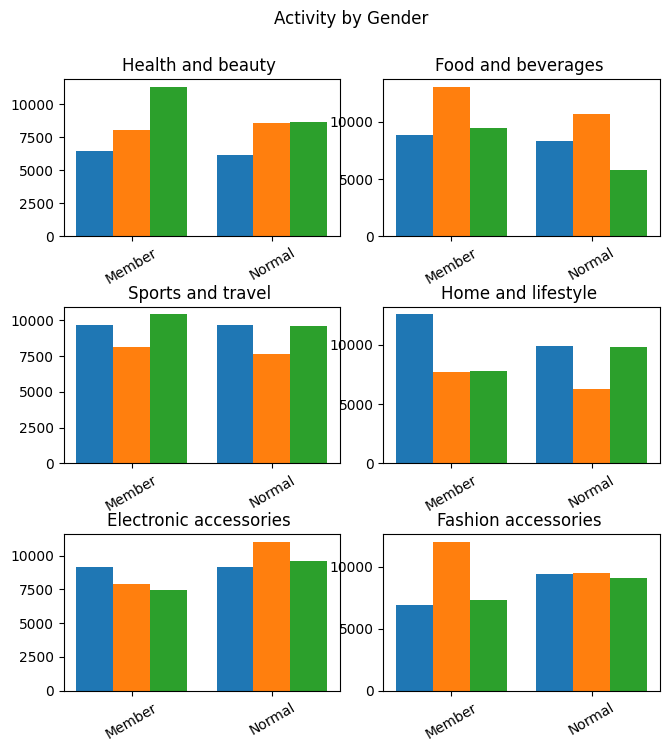

In [90]:
#report_request_test = {'Activity by Gender':{'compare':False, 'categories':[ 'Gender', 'Customer type', 'Product line'], 'ops':{'Rating':'mean'}}}
#report_request_test = {'Activity by Gender':{'compare':False, 'categories':[ 'City', 'Customer type', 'Product line'], 'ops':{'Quantity':'sum'}}}
#report_request_test = {'Activity by Gender':{'compare':True, 'categories':[ 'Payment', 'Customer type', 'hour'], 'ops':{'Total':'count'}}}
#report_request_test = {'Activity by Gender':{'compare':True, 'categories':[ 'Payment', 'Customer type', 'day_name'], 'ops':{'Total':'count'}}}
#report_request_test = {'Activity by Gender':{'compare':True, 'categories':['day_name', 'hour'], 'ops':{'Total':'count'}}}
#report_request_test = {'Activity by Gender':{'compare':True, 'categories':['day_name', 'Product line'], 'ops':{'Total':'count'}}}
#report_request_test = {'Activity by Gender':{'compare':False, 'categories':['day_name', 'Gender'], 'ops':{'Total':'sum'}}}
#report_request_test = {'Activity by Gender':{'type':'bar','compare':False, 'categories':['Gender', 'Customer type', 'Payment'], 'ops':{'Total':'count'}}}
#report_request_test = {'Activity by Gender':{'compare':True, 'categories':[ 'Gender', 'Customer type', 'Product line'], 'ops':{'Rating':'mean', 'cogs':'sum'}}}
#report_request_test = {'Activity by Gender':{'type':'bar','compare':True, 'categories':['Product line', 'Gender'], 'ops':{'Total':'count'}}}
report_request_test = {'Activity by Gender':{'type':'bar','compare':True, 'categories':['Product line', 'Customer type'], 'ops':{'Total':'sum'}}}
create_deliverables(base_df,  target_branch = 'B', report_request = report_request_test)


    
    
    
    if 'transactions per hour' in deliverables:
        log.append('Processing: transactions per hour')
        group_by_hour = target_df.groupby(add_breakout+[target_df['Date_Time'].dt.hour]).agg({'Invoice ID':'count'}).rename(columns={"Invoice ID": f"{target_branch} Totals"})
        group_by_hour[f"{target_branch} Percentage"] = round(group_by_hour[f"{target_branch} Totals"] / target_df.shape[0] * 100,2)
        
        if compare == True:
            for branch in compared_branch:
                group_by_hour_comp = compare_df[compare_df['Branch'] == branch].groupby(add_breakout+[compare_df['Date_Time'].dt.hour]).agg({'Invoice ID':'count'}).rename(columns={"Invoice ID": f"{branch} Totals"})
                group_by_hour_comp[f"{branch} Percentage"] = round(group_by_hour_comp[f"{branch} Totals"] / compare_df[compare_df['Branch'] == branch].shape[0] * 100,2)
                group_by_hour = group_by_hour.merge(group_by_hour_comp, left_index=True, right_index=True)
        output['transactions per hour'] = create_visual_bar(group_by_hour, 'transactions per hour')
        
    if 'transactions per day' in deliverables:
        log.append('Processing: transactions per day')
        group_by_day = target_df.groupby(add_breakout+[target_df['Date_Time'].dt.day_name()]).agg({'Invoice ID':'count'}).rename(columns={"Invoice ID": f"{target_branch} Totals"})
        group_by_day[f"{target_branch} Percentage"] = round(group_by_day[f"{target_branch} Totals"] / target_df.shape[0] * 100,2)
        
        if compare == True:
            for branch in compared_branch:
                group_by_day_comp = compare_df[compare_df['Branch'] == branch].groupby(add_breakout+[compare_df['Date_Time'].dt.day_name()]).agg({'Invoice ID':'count'}).rename(columns={"Invoice ID": f"{branch} Totals"})
                group_by_day_comp[f"{branch} Percentage"] = round(group_by_day_comp[f"{branch} Totals"] / compare_df[compare_df['Branch'] == branch].shape[0] * 100,2)
                group_by_day = group_by_day.merge(group_by_day_comp, left_index=True, right_index=True )
        output['transactions per day'] = create_visual_bar(group_by_day, 'transactions per day')
                
    if 'transactions by payment type' in deliverables:
        log.append('Processing: transactions by payment type')
        group_by_payment = target_df.groupby(add_breakout+['Payment']).agg({'Invoice ID':'count'}).rename(columns={"Invoice ID": f"{target_branch} Totals"})
        group_by_payment[f"{target_branch} Percentage"] = round(group_by_payment[f"{target_branch} Totals"] / target_df.shape[0] * 100,2)
        
        if compare == True:
            for branch in compared_branch:
                group_by_payment_comp = compare_df[compare_df['Branch'] == branch].groupby(add_breakout+['Payment']).agg({'Invoice ID':'count'}).rename(columns={"Invoice ID": f"{branch} Totals"})
                group_by_payment_comp[f"{branch} Percentage"] = round(group_by_payment_comp[f"{branch} Totals"] / compare_df[compare_df['Branch'] == branch].shape[0] * 100,2)
                group_by_payment = group_by_payment.merge(group_by_payment_comp, left_index=True, right_index=True )
        output['transactions by payment type'] = create_visual_bar(group_by_payment, 'transactions by payment type')
    
    if 'Total by Product Line' in deliverables:
        log.append('Processing: Total by Product Line')
        group_by_ProdLine = target_df.groupby(add_breakout+['Product line']).agg({'Total':'sum'}).rename(columns={"Total": f"{target_branch} Totals"})
        group_by_ProdLine[f"{target_branch} Percentage"] = round(group_by_ProdLine[f"{target_branch} Totals"] / target_df['Total'].sum() * 100, 2) 
        
        if compare == True:
            for branch in compared_branch:
                group_by_ProdLine_comp = compare_df[compare_df['Branch'] == branch].groupby(add_breakout+['Product line']).agg({'Total':'sum'}).rename(columns={"Total": f"{branch} Totals"})
                group_by_ProdLine_comp[f"{branch} Percentage"] = round(group_by_ProdLine_comp[f"{branch} Totals"] / compare_df[compare_df['Branch'] == branch]['Total'].sum() * 100, 2)
                group_by_ProdLine = group_by_ProdLine.merge(group_by_ProdLine_comp, left_index=True, right_index=True )
        output['Total by Product Line'] = create_visual_bar(group_by_ProdLine, 'Total by Product Line')


In [525]:
#old
def create_visual_bar(grouped_df, title):
    """This functions receives a grouped df and returns a bar chart"""
    #column analysis
    total_cols = []
    for col in grouped_df.columns:
        if re.search('Totals', col):
            total_cols.append(col)
    width = (1 / len(total_cols)) - 0.07    
    
    if isinstance(grouped_df.index, pd.MultiIndex): #cust_breakout or gender_breakout = True
        #index analysis    
        factor_names = grouped_df.index.names
        factor_number = len(factor_names)
        factor_levels = {}
        
        for index in grouped_df.index:
            for factor in range(factor_number):
                if factor_levels.get(factor_names[factor]) == None:
                    factor_levels[factor_names[factor]] = {index[factor]}
                else:
                    factor_levels[factor_names[factor]].add(index[factor])   
                 
        factor_levels.pop(list(factor_levels.keys())[-1])
        df_filters = list(itertools.product(*factor_levels.values()))
        
        # Chart Prepare
        df_filters_len = len(df_filters)
        if df_filters_len == 4:
            fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(7,5))
            plot_seq = zip([(0,0), (0,1), (1,0), (1,1)], df_filters)
            
        else:
            fig, axs = plt.subplots(ncols=2, nrows = 1, figsize=(7,2.5))
            plot_seq = enumerate(df_filters)
        
        fig.suptitle(title) 
        fig.tight_layout(pad=2.2, w_pad=0.05, h_pad=3)
        
        for chart_indx, segment in plot_seq:
            filtered_df =  grouped_df
            segment_title = ''
            for val_indx, factor in enumerate(factor_levels.keys()):
                segment_title += str(segment[val_indx]) + ' '
                filtered_df =  filtered_df[filtered_df.index.isin([segment[val_indx]], level=val_indx)]
               
            filtered_df.reset_index(inplace = True)
            index_col_val = filtered_df[factor_names[-1]].unique() #this variable helps detect special cases where specific order is needed, example: days, months
            
            # this section adjust x labels to avoid presenting numbers as x_ticks
            if 'Monday' in index_col_val: #adjust days
                mapping = {'Monday':0, 'Tuesday':1 , 'Wednesday':2 , 'Thursday':3 , 'Friday':4 , 'Saturday':5 , 'Sunday':6}
                filtered_df['cat_code'] = filtered_df[factor_names[-1]].map(mapping)
            elif 'January' in index_col_val: #to do
                pass 
            else:
                filtered_df['cat_code'] = filtered_df[factor_names[-1]].astype('category').cat.codes
            filtered_df.sort_values(by = 'cat_code', ascending = True, inplace=True)
            axs[chart_indx].set_xticks(ticks = filtered_df['cat_code'], labels=filtered_df[factor_names[-1]])
            axs[chart_indx].set_title(segment_title)
            axs[chart_indx].tick_params(axis='x', labelrotation = 45)
            
            for col_indx, col in enumerate(total_cols):
                axs[chart_indx].bar(filtered_df.index+(width*(col_indx)), filtered_df[col], width)
        output = fig
        
    else: # no breakout is selected
        index_name = grouped_df.index.name
        
        grouped_df.reset_index(inplace = True)
        index_col_val = grouped_df[index_name].unique()
        
        if 'Monday' in index_col_val: #adjust days
                mapping = {'Monday':0, 'Tuesday':1 , 'Wednesday':2 , 'Thursday':3 , 'Friday':4 , 'Saturday':5 , 'Sunday':6}
                grouped_df['cat_code'] = grouped_df[index_name].map(mapping)
        elif 'January' in index_col_val: #to do
            pass 
        else:
            grouped_df['cat_code'] = grouped_df[index_name].astype('category').cat.codes
        grouped_df.sort_values(by = 'cat_code', ascending = True, inplace=True)
        #chart prepare
        plot = plt.figure(figsize=(4,4), layout='constrained')
        for col_indx, col in enumerate(total_cols):
            plt.bar(grouped_df.index+(width*(col_indx)), grouped_df[col], width)
        plt.xticks(ticks = grouped_df['cat_code'], labels=grouped_df[index_name], rotation = 45)
        plt.title(title)
        output = plot
    return output

In [ ]:
test = create_deliverables(base_df, target_branch = 'A',cust_breakout = True, gender_breakout = True, compare = False)

In [571]:
list({'x':'y'}.keys())[0]

'x'